# Лабораторная работа №8. Рекуррентные нейронные сети для анализа временных рядов

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Задание 1.
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

In [2]:
import os
import pandas as pd


df = pd.read_csv(os.path.join('data', 'Sunspots.csv'))
df = df.drop(columns='Unnamed: 0')
df = df.rename(columns={'Monthly Mean Total Sunspot Number': 'value', 'Date': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,value
date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

/home/a_stasiuk/anaconda3/envs/neural-networks/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


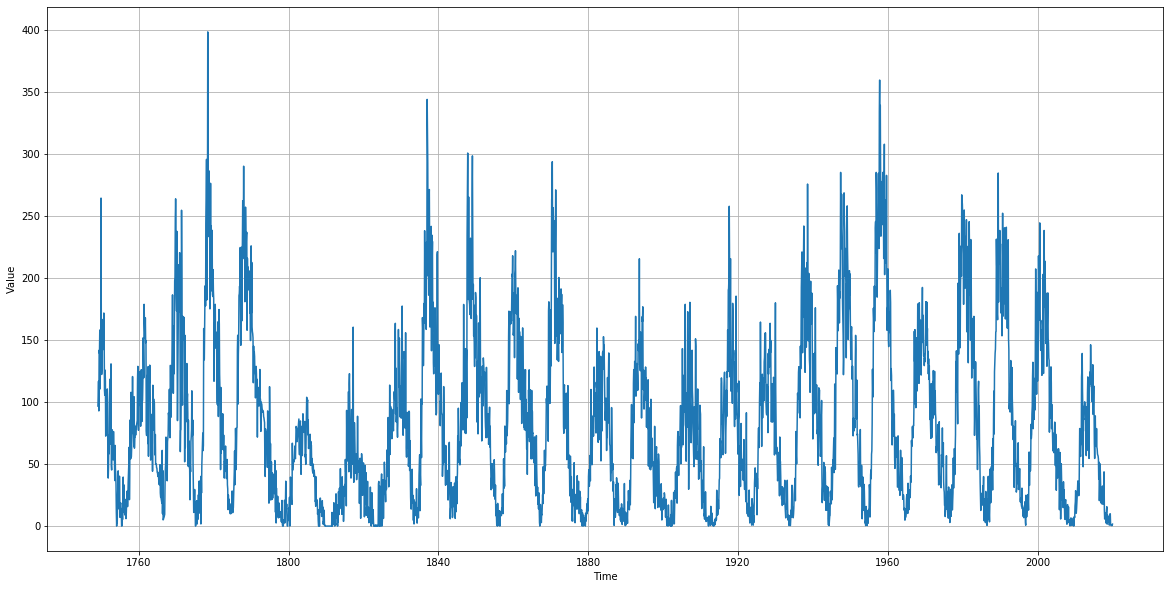

In [4]:
plt.figure(figsize=(20, 10))
plot_series(df.index, df['value'])

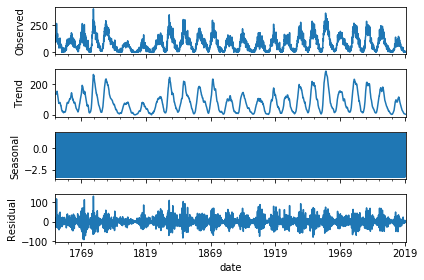

In [5]:
import statsmodels.api as sm
import matplotlib


decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()

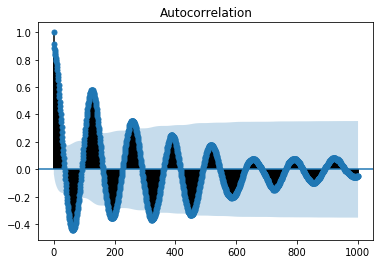

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['value'], lags=1000)
plt.show()

## Задание 2.
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=False)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42, shuffle=False)

In [8]:
train_df.count(), test_df.count(), valid_df.count()

(value    2633
 dtype: int64, value    326
 dtype: int64, value    293
 dtype: int64)

## Задание 3.
Примените модель ARIMA для прогнозирования значений данного временного ряда.

In [9]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_df['value'], freq='M', order=(5, 0, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                 2633
Model:                     ARMA(5, 1)   Log Likelihood              -12270.861
Method:                       css-mle   S.D. of innovations             25.561
Date:                Sun, 19 Apr 2020   AIC                          24557.722
Time:                        13:37:54   BIC                          24604.729
Sample:                    01-31-1749   HQIC                         24574.742
                         - 05-31-1968                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          82.7776     12.734      6.501      0.000      57.820     107.735
ar.L1.value     1.0258      0.123      8.347      0.000       0.785       1.267
ar.L2.value    -0.1417      0.076     -1.873      0.061      -0.290       0.007
ar.L3.value     0.0365      0.032      1.146      0.252      -0.026       0.099
ar.L4.value     0.0408      0.030      1.383      0.167      -0.017       0.099
ar.L5.value     0.0176      0.029      0.607      0.544      -0.039       0.074
ma.L1.value    -0.4523      0.122     -3.721      0.000      -0.691      -0.214
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0189           -0.0000j            1.0189           -0.0000
AR.2            1.0581           -1.8195j            2.1048           -0.1662
AR.3            1.0581           +1.8195j            2.1048            0.1662
AR.4           -2.7279           -2.2692j            3.5484           -0.3896
AR.5           -2.7279           +2.2692j            3.5484            0.3896
MA.1            2.2110           +0.0000j            2.2110            0.0000
-----------------------------------------------------------------------------
"""

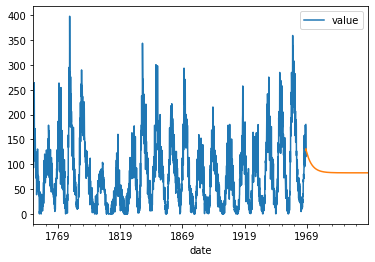

In [10]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta

forecast_start_date = train_df.index[-1] 
forecast_end_date = forecast_start_date + relativedelta(years=+50)
forecast = model_fit.predict(
    start=forecast_start_date,
    end=forecast_end_date,
    dynamic=True
) 
train_df.plot()
forecast.plot()
plt.show()

## Задание 4.
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

In [11]:
def normalize_values(df, mean_value, std_value):
    df['normal'] = (df.value - mean_value) / std_value

In [12]:
mean_value = train_df.value.mean()
std_value = train_df.value.std()

normalize_values(train_df, mean_value, std_value)
normalize_values(valid_df, mean_value, std_value)
normalize_values(test_df, mean_value, std_value)

/home/a_stasiuk/anaconda3/envs/neural-networks/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
def dataset_from_series(df, lookback_period=12):
    X, y = [], []

    for idx in range(lookback_period, len(df)):
        history_vector = np.array(df.normal[idx-lookback_period:idx], dtype=np.float32)
        next_value = df.normal[idx]

        X.append(history_vector)
        y.append(next_value)
    
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)
    
    y = np.array(y)

    return X, y

In [20]:
import tensorflow as tf


batch_size = 256

train_data = tf.data.Dataset.from_tensor_slices(dataset_from_series(train_df))
train_data = train_data.shuffle(10000).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices(dataset_from_series(valid_df))
val_data = val_data.batch(batch_size).repeat()

In [21]:
train_data

<RepeatDataset shapes: ((None, 12, 1), (None,)), types: (tf.float32, tf.float64)>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, Lambda, GRU
from tensorflow.keras.optimizers import SGD


network = Sequential([
    GRU(12, input_shape=(12, 1), return_sequences=True),
    GRU(12),
    Dense(1)
])

network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 12, 12)            540       
_________________________________________________________________
gru_3 (GRU)                  (None, 12)                936       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


In [23]:
network.compile(loss='mse', optimizer='adam')
history = network.fit(
    train_data,
    validation_data=val_data,
    steps_per_epoch=100,
    validation_steps=10,
    epochs=100,
    verbose=0
)

In [24]:
x_test, y_test = dataset_from_series(test_df)

In [25]:
y_test.shape

(314,)

In [26]:
network.evaluate(x=x_test, y=y_test)

314/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.07946312942417563

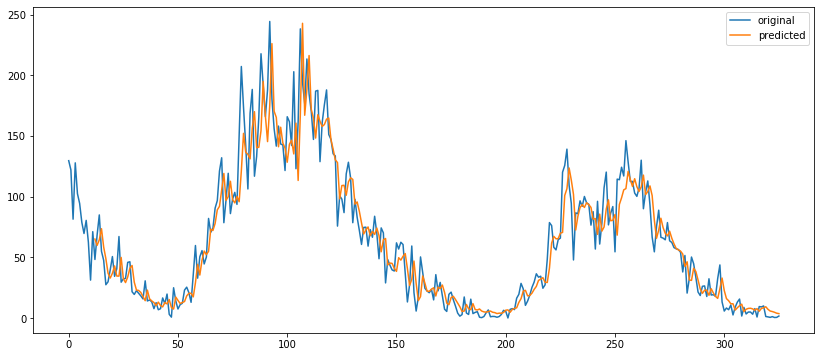

In [31]:
y_pred = [np.nan] * 12 + (mean_value + network.predict(x_test) * std_value).flatten().tolist()

plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(test_df)), test_df.value, label="original")
plt.plot(np.arange(len(test_df)), y_pred, label="predicted")
plt.legend()
plt.show()